In [1]:
import os
import glob
import lzma
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 
import torch 
from sklearn.metrics import mean_squared_error

In [2]:
'''modify path to target model here'''
model_path = 'pred_1726371137780.xz'

In [3]:
all_preds = {}
all_models = []
df = pd.read_csv(model_path)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
df = df.sort_values(by='Month', ascending=True).reset_index()
all_preds[model_path] = df
all_models.append(model_path)

In [4]:
def check_chronological_order(df,timecol = 'Month'):
    df[timecol] = pd.to_datetime(df[timecol], format='%Y-%m-%d', errors='coerce')
    for i in range(1, len(df)):
        if df[timecol].iloc[i] < df[timecol].iloc[i - 1]:
            print(f"Chronological order breaks at row {i}, Month: {df[timecol].iloc[i]}")
            return False
    print(f"The {timecol} column is in chronological order.")
    return True
def plot_returns(df, method, cumulative=True, pred_weight = False, savedir= None):
    #df -> [timestep, decile, return_equal, return_pred]
    # for each decile, plot the return across all timesteps
    check_chronological_order(df, 'timestep')
    plt.figure(figsize=(10, 6))
    for i in range (10):
        df_decile = df[df['decile'] == i].copy()
        df_decile = df_decile.sort_values('timestep')
        if cumulative and method == 'sum': 
            df_decile['cumulative_return_equal'] = df_decile['return_equal'].cumsum()
            df_decile['cumulative_return_pred'] = df_decile['return_pred'].cumsum()
        elif cumulative and method == 'logsum':
            df_decile['cumulative_return_equal'] = np.exp(np.log1p(df_decile['return_equal']).cumsum()) - 1
            df_decile['cumulative_return_pred'] = np.exp(np.log1p(df_decile['return_pred']).cumsum()) - 1
        else:
            df_decile['cumulative_return_equal'] = df_decile['return_equal']
            df_decile['cumulative_return_pred'] = df_decile['return_pred']
        if pred_weight:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_pred'],  label=f'Decile {i}')
        else:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_equal'], label=f'Decile {i}')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Abnormal Return' if cumulative else 'Return')
    plt.title('Cumulative Abnormal Returns Over Time' if cumulative else 'Abnormal Returns Over Time')
    plt.suptitle('Prediction-weighted' if pred_weight else 'Equally-weighted', fontsize=9, y=0.87)
    if savedir is not None:
        plt.savefig(savedir+"cumulative_abnormal_return.png", dpi=300, bbox_inches='tight')
    #plt.ylim(-1, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
def decile_plot(selected_model=all_models[0], ensemble=True):
    if ensemble: 
        preds_list = []
        for model in all_models:
            model_pred = all_preds[model]['future_ab_monthly_return_pred'].values
            preds_list.append(model_pred)
        final_preds = np.mean(np.array(preds_list), axis=0)
        df = all_preds[selected_model].copy()
        df['future_ab_monthly_return_pred'] = final_preds
    else:
        df = all_preds[selected_model].copy()
    #decile plot 
    df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
    df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
    check_chronological_order(df)
    df_monthly_return = calculate_month_return(df)
    df_monthly_return['timestep']=pd.to_datetime(df_monthly_return['timestep'])
    plot_returns(df_monthly_return, method='sum', pred_weight=True, savedir=None)
    return df_monthly_return, df
def calculate_month_return(df, predcol='future_ab_monthly_return_pred', decilecol='decile'):
    #df-> [FundId, month, decile, prediciton]
    #return df -> [timestep, decile, return_equal, return_pred]
    #return_equal -> equally weighted monthly return 
    #return_pred -> predicion weighted monthly return 
    results = []
    for timestep in df['Month'].unique():
        df_timestep = df[df['Month'] == timestep]
        for decile in df_timestep[decilecol].unique():
            df_decile = df_timestep[df_timestep[decilecol] == decile]
            return_equal = df_decile['future_ab_monthly_return'].mean() #equal weight
            #predition weight 
            month_returns = torch.tensor(df_decile['future_ab_monthly_return'].values, dtype=torch.float32)
            month_predictions = torch.tensor(df_decile[predcol].values, dtype=torch.float32)
            weights = month_predictions.clone()
            if decile >= 5:
                weights -= torch.min(month_predictions)
            elif decile < 5:
                weights -= torch.max(month_predictions)
            return_pred = torch.sum(month_returns * weights) / torch.sum(weights)
            #add to output 
            results.append({
                'timestep': timestep,
                'decile': decile,
                'return_equal': return_equal,
                'return_pred': return_pred.item()
            })
    result_df = pd.DataFrame(results)
    return result_df

pred_1726371137780.xz
The Month column is in chronological order.
The timestep column is in chronological order.


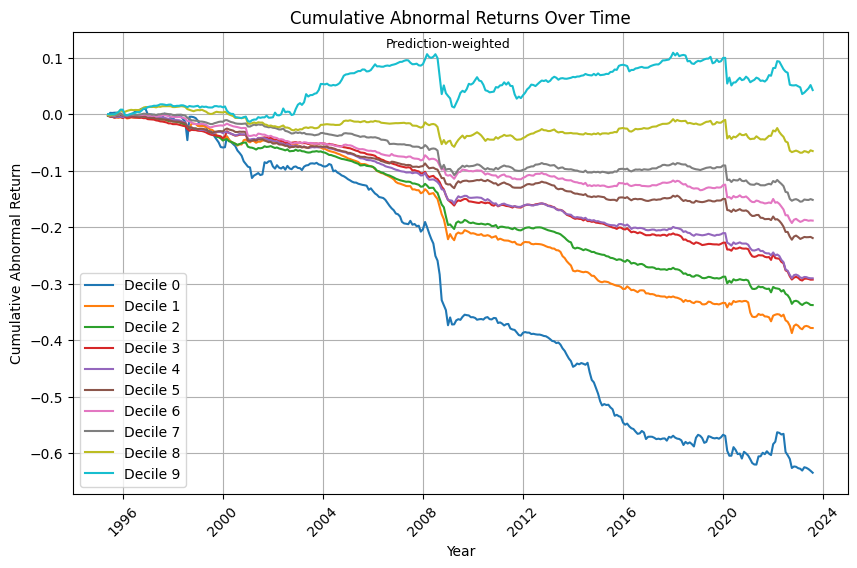

In [5]:
print(all_models[0])
df_monthly_return, df = decile_plot(selected_model=all_models[0], ensemble=False)